<h1>Bacterial and viral pneumonia detection(detecting covid-as viral pneumonia)</h1>

In [16]:
# Imports
import torch
import torchvision
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from tqdm.notebook import tqdm
import pandas as pd
import os
from skimage import io

In [17]:
# TB dataloader
class CovidDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)
        
        return (image, y_label)

In [18]:
class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

In [19]:
# Simple CNN
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=8,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv3 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv4 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv5 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.fc1 = nn.Linear(3136*2, num_classes)
#         self.fc2 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):              # 32 * 1 * 224 * 224
        x = F.relu(self.conv1(x))      # 32 * 8 * 224 * 224
        x = self.pool(x)               # 32 * 8 * 112 * 112
        x = F.relu(self.conv2(x))      # 32 * 16 * 112 * 112
        x = self.pool(x)               # 32 * 16 * 56 * 56
        x = F.relu(self.conv3(x))      # 32 * 32 * 56 * 56
        x = self.pool(x)               # 32 * 32 * 28 * 28
        x = F.relu(self.conv4(x))      # 32 * 64 * 28 * 28
        x = self.pool(x)               # 32 * 64 * 14 * 14
        x = F.relu(self.conv5(x))      # 32 * 128 * 14 * 14
        x = self.pool(x)               # 32 * 128 * 7 * 7
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
        return x

In [20]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)


    model.train()
    return num_correct/num_samples

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device = torch.device("cuda")
device

device(type='cuda')

In [36]:
# Hyperparameters
in_channels = 1    # since the data is grayscale
num_classes = 2    # normal and TB
learning_rate = 0.001
batch_size = 32
num_epochs = 30

In [37]:
dataset = CovidDataset(
    csv_file=r"C:\Users\Dhanraj Katkar\Desktop\github\COVID-CT\Images-processed\covid.csv",
    root_dir=r"C:\Users\Dhanraj Katkar\Desktop\github\COVID-CT\Images-processed\all",
    transform=transforms.Compose(
        [transforms.ToPILImage(),
         transforms.Resize((224, 224)),
#          transforms.RandomAdjustSharpness(sharpness_factor=2),
         transforms.RandomAutocontrast(),
         transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.2, hue=0),
         transforms.Grayscale(num_output_channels=1),
         transforms.ToTensor(),]),
    )
len(dataset)

746

In [38]:
train_set, test_set = torch.utils.data.random_split(dataset, [int(len(dataset)*.9), (len(dataset) - int(len(dataset)*.9))])
# sample_weights = [0] * len(dataset)

# for idx, (data, label) in enumerate(train_set):
#     class_weight = class_weights[label]
#     sample_weights[idx] = class_weight

# sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)



train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True) 

In [39]:
# Model
model = CNN(in_channels=in_channels, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([349., 397.], device=device))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [40]:
# Training
for epoch in range(num_epochs):
    losses = []
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        scores = model(data)
        loss = criterion(scores, targets)
        
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses):.5f}")
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")

  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 0 is 0.69222


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 1 is 0.68597


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 2 is 0.66909


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 3 is 0.64142


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 4 is 0.61982


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 5 is 0.59460


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 6 is 0.57928


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 7 is 0.55977


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 8 is 0.52775


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 9 is 0.50062


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 10 is 0.47127


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 11 is 0.43000


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 12 is 0.41656


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 13 is 0.37593


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 14 is 0.38078


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 15 is 0.34043


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 16 is 0.40473


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 17 is 0.31700


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 18 is 0.26617


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 19 is 0.23217


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 20 is 0.20917


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 21 is 0.24988


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 22 is 0.21814


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 23 is 0.17755


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 24 is 0.14803


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 25 is 0.10504


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 26 is 0.12520


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 27 is 0.09395


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 28 is 0.05562


  0%|          | 0/19 [00:00<?, ?it/s]

Cost at epoch 29 is 0.06485
Accuracy on training set: 97.65


<h3> Increasing accuracy of the model.</h3 
<ul>
<li>adding more data as model is overfitting in few epochs</li>
<li>improving network structure after seeing new data</li>
<li>implementing sampling techniques</li>
<li>augmenting data</li>
</ul>

In [51]:
print(f"Test set accuracy: {check_accuracy(test_loader, model)*100:.2f}")

Test set accuracy: 81.33


0 is Normal and 1 is covid positive


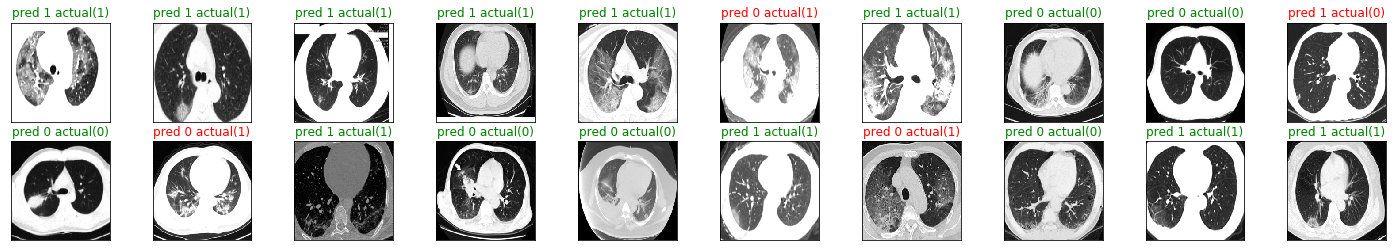

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device=device)
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = output.max(1)
# prep images for display
images = images.cpu()
print("0 is Normal and 1 is covid positive")
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("pred {} actual({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))


In [48]:
model_scripted = torch.jit.script(model)
model_scripted.save('entire_model.pt')

In [49]:
# TODO create flask based deployment
model_saved = torch.jit.load('entire_model.pt')
model_saved.eval()

RecursiveScriptModule(
  original_name=CNN
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (pool): RecursiveScriptModule(original_name=MaxPool2d)
  (conv2): RecursiveScriptModule(original_name=Conv2d)
  (conv3): RecursiveScriptModule(original_name=Conv2d)
  (conv4): RecursiveScriptModule(original_name=Conv2d)
  (conv5): RecursiveScriptModule(original_name=Conv2d)
  (fc1): RecursiveScriptModule(original_name=Linear)
  (dropout): RecursiveScriptModule(original_name=Dropout)
)